![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn import metrics

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [5]:
# Celda 1


In [6]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [11]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)

In [12]:
y_pred = tree_predict(X_test, tree)

In [13]:
acc_tree = metrics.accuracy_score(y_test, y_pred)
acc_tree

0.8599884526558892

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [20]:
n_samples = X_train.shape[0]
#n_samples = X_train.index
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([5584, 3021,  126, ..., 5071, 3827, 6567]),
 array([4604, 4178, 3870, ..., 1648, 5903, 6685]),
 array([4973, 2652, 3827, ..., 1676, 4097,  953]),
 array([ 980, 5072, 1378, ..., 2375, 6641, 2212]),
 array([4315, 3981, 3743, ..., 3502, 2423,  177]),
 array([2297, 3830, 5310, ..., 5500,  623, 6572]),
 array([4747, 1770, 5352, ..., 5697, 5251, 1006]),
 array([  55, 2520, 3947, ..., 6005, 3791, 6828]),
 array([6390, 6156, 2093, ..., 4607, 5982, 5695]),
 array([3091, 2982, 4079, ..., 6242, 4246, 4072])]

In [21]:
# Construcción un árbol de decisión para cada muestra boostrap

# Definición del modelo usando DecisionTreeRegressor de sklearn
treecla = DecisionTreeClassifier(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_sample = X_train.iloc[sample]
    y_train_sample = y_train.iloc[sample]
    treecla.fit(X_train_sample, y_train_sample)
    y_pred.iloc[:,i] = treecla.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
257343,0,0,0,0,0,0,0,0,0,0
326011,0,0,0,0,0,0,0,0,0,0
242354,1,1,1,1,1,1,0,1,1,1
266376,1,1,1,1,1,1,1,1,1,1
396954,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
144298,1,0,1,1,1,1,1,1,1,1
364521,1,1,1,1,1,1,1,1,1,1
120072,1,1,1,1,1,1,1,1,1,1
99878,0,0,0,0,0,0,0,0,0,0


In [22]:
# Votación mayoritaria
y_pred = (y_pred.sum(axis=1) >= (n_B / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
acc_bagging = metrics.accuracy_score(y_test, y_pred)
acc_bagging

0.8521939953810623

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [28]:
# Uso de BaggingClassifier de la libreria (sklearn) donde se usa el modelo DecisionTreeClassifier como estimador

bagcla = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, 
                          bootstrap=True, oob_score=True, random_state=1,max_features=2)

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagcla.fit(X_train, y_train)
y_pred = bagcla.predict(X_test)
acc_bagging = metrics.accuracy_score(y_test, y_pred)
acc_bagging

0.8493071593533488

In [29]:
# Cálculo del error the out-of-bag con el R-cuadrado (no con el MSE)
bagcla.oob_score_

0.7818233537192434

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [225]:
# Celda 4
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier(random_state=1, n_jobs=-1)

#Impresión de desempeño del modelo usando la función cross_val_score  (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
pd.Series(cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")).mean()

0.8367287517780939

In [226]:
clf = RandomForestClassifier(random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [227]:
acc_ramdom = metrics.accuracy_score(y_test, y_pred)
acc_ramdom

0.8429561200923787

In [195]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

### Calibración de n_estimators
**n_estimators** es la cantidad de árboles a contruir dentro del bosque aleatorio.

In [196]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(1, 310, 10)
#list(estimator_range)

In [197]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, max_features=None, max_depth=None, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

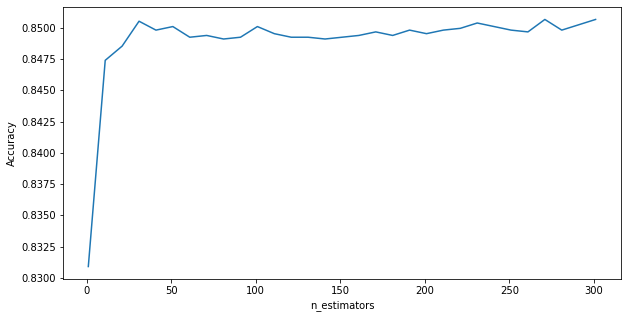

In [198]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.figure(figsize=(10,5))
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [199]:
# Mejor accuracy (desempeño del modelo) y su correspondiente numero de estiamdosres
acc_opt_n_estimators, opt_n_estimators = sorted(zip(accuracy_scores, estimator_range))[::-1][0]
acc_opt_n_estimators, opt_n_estimators

(0.8506659769817665, 271)

In [214]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=None, max_depth=None, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [216]:
acc_n_estimators = metrics.accuracy_score(y_test, y_pred)
acc_n_estimators

0.8539260969976905

### Calibracióm max_features
**max_features** es el número de variables que se deben considerar en cada árbol.

In [200]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    #clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=feature, random_state=1, n_jobs=-1)
    clf = RandomForestClassifier(max_features=feature, n_estimators=opt_n_estimators, max_depth=None, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

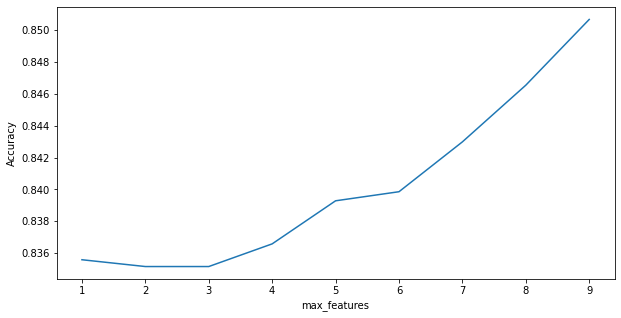

In [201]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.figure(figsize=(10,5))
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [202]:
# Mejor accuracy (desempeño del modelo) y su correspondiente numero de features
acc_opt_n_features, opt_n_features = sorted(zip(accuracy_scores, feature_range))[::-1][0]
acc_opt_n_features, opt_n_features

(0.8506659769817665, 9)

In [217]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=opt_n_features, max_depth=None, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [218]:
acc_opt_n_features = metrics.accuracy_score(y_test, y_pred)
acc_opt_n_features

0.8539260969976905

### Calibracióm max_depth
**max_depth** es la maxima profundidad de cada árbol.

In [203]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 51)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    #clf = RandomForestClassifier(max_features=opt_n_features, n_estimators=opt_n_estimators, max_depth=depth, random_state=1, n_jobs=-1)
    clf = RandomForestClassifier(max_features=None, n_estimators=opt_n_estimators, max_depth=depth, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

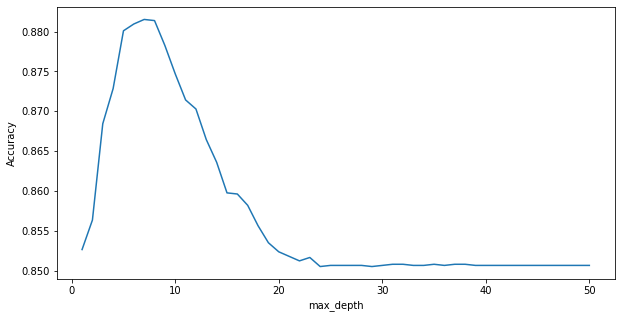

In [204]:
# Gráfica el desempeño del modelo vs max_depth
plt.figure(figsize=(10,5))
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [205]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
acc_opt_max_depth, opt_max_depth = sorted(zip(accuracy_scores, max_depth_range))[::-1][0]
acc_opt_max_depth, opt_max_depth

(0.8815284333376437, 7)

In [221]:
clf = RandomForestClassifier(n_estimators=opt_n_estimators, max_features=None, max_depth=opt_max_depth, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [224]:
acc_opt_max_depth = metrics.accuracy_score(y_test, y_pred)
acc_opt_max_depth

0.8839491916859122

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [228]:
# Celda 6
# Importación y definición de modelo XGBClassifier
clf = XGBClassifier(eval_metric = "error")

# Impresión de desempeño del modelo usando la función cross_val_score 
# (más detalles en https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy").mean()

0.8734215375662744

In [229]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [230]:
acc_xgb = metrics.accuracy_score(y_test, y_pred)
acc_xgb

0.8856812933025404

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

### Calibracióm learning_rate (eta)
**learning_rate** Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative. Range: [0,1]

In [260]:
# Lista de valores para calibrar el criterio de Tasa de aprendizaje (Learning Rate)
learning_rate_range = np.arange(0.01, 0.3, 0.01)
learning_rate_range

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])

In [261]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de tasa de aprendizaje (Learning Rate)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for learning_rate in learning_rate_range:
    clf = XGBClassifier(eval_metric = "error", eta=learning_rate)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

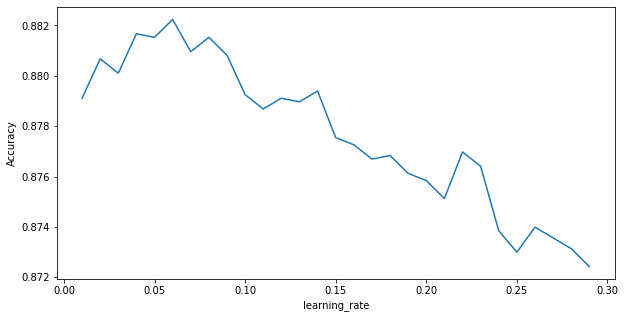

In [262]:
# Gráfica el desempeño del modelo vs learning_rate
plt.figure(figsize=(10,5))
plt.plot(learning_rate_range, accuracy_scores)
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')

In [263]:
# Mejor accuracy (desempeño del modelo) y su correspondiente learning_rate
acc_opt_learning_rate, opt_learning_rate = sorted(zip(accuracy_scores, learning_rate_range))[::-1][0]
acc_opt_learning_rate, opt_learning_rate

(0.8822382564981248, 0.060000000000000005)

In [268]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [269]:
acc_opt_learning_rate = metrics.accuracy_score(y_test, y_pred)
acc_opt_learning_rate

0.8853926096997691

### Calibración min_split_loss (Gamma)
***min_split_loss*** Minimum loss reduction required to make a further partition on a leaf node of the tree. range: [0,∞]

In [284]:
# Lista de valores para calibrar el criterio de Tasa de aprendizaje (Gamma)
min_split_loss_range = np.arange(13, 18, 0.1)
min_split_loss_range

array([13. , 13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. ,
       14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1,
       15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2,
       16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. , 17.1, 17.2, 17.3,
       17.4, 17.5, 17.6, 17.7, 17.8, 17.9])

In [285]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de min_split_loss
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for min_split_loss in min_split_loss_range:
    clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=min_split_loss)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

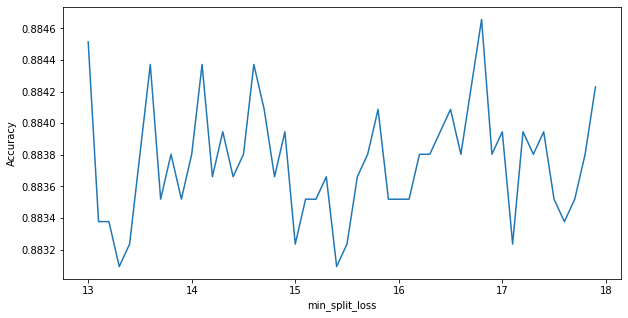

In [286]:
# Gráfica el desempeño del modelo vs learning_rate
plt.figure(figsize=(10,5))
plt.plot(min_split_loss_range, accuracy_scores)
plt.xlabel('min_split_loss')
plt.ylabel('Accuracy')

In [288]:
# Mejor accuracy (desempeño del modelo) y su correspondiente learning_rate
acc_opt_min_split_loss, opt_min_split_loss = sorted(zip(accuracy_scores, min_split_loss_range))[::-1][0]
acc_opt_min_split_loss, opt_min_split_loss

(0.884657272403983, 16.799999999999986)

In [289]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [290]:
acc_opt_min_split_loss = metrics.accuracy_score(y_test, y_pred)
acc_opt_min_split_loss

0.8877020785219399

### Calibración colsample_bytree
***colsample_bytrees*** número de predictores considerados a en cada división.

In [293]:
# Lista de valores para calibrar el criterio de número de predictores considerados a en cada división (colsample_bytree)
colsample_by_tree_range = np.arange(0, 1.1, 0.1)
colsample_by_tree_range

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [294]:
# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor del número de predictores considerados a en cada división.
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la  tasa de aprendizaje
for colsample_by_tree in colsample_by_tree_range:
    clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss, colsample_bytree=colsample_by_tree)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

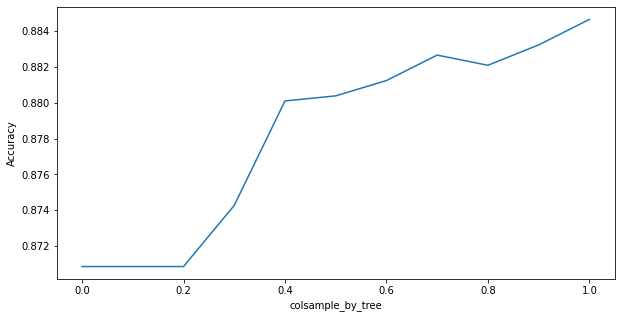

In [295]:
# Gráfica el desempeño del modelo vs número de predictores considerados a en cada división.
plt.figure(figsize=(10,5))
plt.plot(colsample_by_tree_range, accuracy_scores)
plt.xlabel('colsample_by_tree')
plt.ylabel('Accuracy')

In [296]:
# Mejor accuracy (desempeño del modelo) y su correspondiente número de predictores considerados a en cada división.
acc_opt_colsample_by_tree, opt_colsample_by_tree = sorted(zip(accuracy_scores, colsample_by_tree_range))[::-1][0]
acc_opt_colsample_by_tree, opt_colsample_by_tree

(0.884657272403983, 1.0)

In [297]:
clf = XGBClassifier(eval_metric = "error", eta=opt_learning_rate, gamma=opt_min_split_loss, colsample_bytree=opt_colsample_by_tree)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [298]:
acc_opt_colsample_by_tree = metrics.accuracy_score(y_test, y_pred)
acc_opt_colsample_by_tree

0.8877020785219399

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [211]:
# Celda 8


### Enlaces
- https://www.cienciadedatos.net/documentos/33_arboles_de_prediccion_bagging_random_forest_boosting
- https://www.datacamp.com/community/tutorials/xgboost-in-python+
- https://xgboost.readthedocs.io/en/latest/index.html